## Analysis Setup

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
import os
import csv
from scipy.stats import linregress

# Study data files
FEMA_data = "FEMA_data.csv"
US_Presidents = "USpresidents.csv"

FEMA_df = pd.read_csv(FEMA_data)
Pres_df = pd.read_csv(US_Presidents)

In [2]:
# Write missing president data to president dataframe through 2017 (FEMA data end date) - commenting out after running once to prevent adding multiple times
# with open(US_Presidents, "a") as myfile:
#     writer=csv.writer(myfile, delimiter=",")
#     myfile.write('\n')
#     writer.writerow(['2014', 'Barack Obama', 'Democrat'])
#     writer.writerow(['2015', 'Barack Obama', 'Democrat'])
#     writer.writerow(['2016', 'Barack Obama', 'Democrat'])
#     writer.writerow(['2017', 'Donald Trump', 'Republican'])

In [3]:
# Cleaning up data frames & preparing to merge 
FEMA_df['Year'] = pd.DatetimeIndex(FEMA_df['Start Date']).year
FEMA_df['End Year'] = pd.DatetimeIndex(FEMA_df['End Date']).year
Pres_df = Pres_df.rename(columns={"Years (after inauguration)":"Year"})

In [4]:
# Merge FEMA dataframe and President dataframe on Year columns
merged_df = pd.merge(FEMA_df, Pres_df, on="Year", how="left")

In [5]:
# Cleaning out unnecesssary columns and dropping duplicate Declarations
cleaned_df = merged_df[["Year", "President", "Party", "Declaration Number","Declaration Type", "Disaster Type", "State", "Start Date", "End Date"]]
cleaned_df = cleaned_df.drop_duplicates(subset = ["Declaration Number"], keep="first")

In [6]:
# Editing error in FEMA data
cleaned_df.loc[(cleaned_df['Declaration Number'] == 'DR-4255'), 'Start Date'] = '12/26/2015'
cleaned_df.loc[(cleaned_df['Declaration Number'] == 'DR-4255'), 'Year'] = 2015

In [7]:
# Adding column in cleaned_df for Disaster Length
cleaned_df["Disaster Length"] = pd.to_datetime(cleaned_df["End Date"]) - pd.to_datetime(cleaned_df["Start Date"])

In [8]:
# Removing 2017 from dataframe
drop_year = cleaned_df[cleaned_df["Year"]==2017].index
cleaned_df.drop(drop_year, inplace = True)

In [9]:
# Run cleaned_df
cleaned_df

,Year,President,Party,Declaration Number,Declaration Type,Disaster Type,State,Start Date,End Date,Disaster Length
0,1953,Dwight D. Eisenhower,Republican,DR-1,Disaster,Tornado,GA,05/02/1953,05/02/1953,0 days
1,1953,Dwight D. Eisenhower,Republican,DR-2,Disaster,Tornado,TX,05/15/1953,05/15/1953,0 days
2,1953,Dwight D. Eisenhower,Republican,DR-3,Disaster,Flood,LA,05/29/1953,05/29/1953,0 days
3,1953,Dwight D. Eisenhower,Republican,DR-4,Disaster,Tornado,MI,06/02/1953,06/02/1953,0 days
4,1953,Dwight D. Eisenhower,Republican,DR-5,Disaster,Flood,MT,06/06/1953,06/06/1953,0 days
...,...,...,...,...,...,...,...,...,...,...
46060,2016,Barack Obama,Democrat,DR-4290,Disaster,Flood,MN,09/21/2016,09/24/2016,3 days
46070,2016,Barack Obama,Democrat,DR-4292,Disaster,Flood,PA,10/20/2016,10/21/2016,1 days
46074,2016,Barack Obama,Democrat,DR-4293,Disaster,Fire,TN,11/28/2016,12/09/2016,11 days
46086,2016,Barack Obama,Democrat,DR-4296,Disaster,Storm,OR,12/14/2016,12/17/2016,3 days


# Null Testing

In [10]:
# Finding number of disaster declarations by president & number of years each president served
president_group = cleaned_df.groupby(["President"])["Declaration Number"].nunique()
president_term = cleaned_df.groupby(["President"])["Year"].nunique()

# Combine president_term and president_group into dataframe
president_disaster_count = pd.DataFrame(data=
        {"President Term":president_term, 
        "Disaster Count":president_group})

president_disaster_count

,President Term,Disaster Count
President,,
Barack Obama,8,763
Bill Clinton,8,554
Dwight D. Eisenhower,8,106
George Bush,4,159
George W. Bush,8,1033
Gerald Ford,3,133
Jimmy Carter,4,176
John F. Kennedy,2,34
Lyndon B. Johnson,6,111


In [11]:
# Add the Party to the president_disaster_count dataframe by merging with cleaned_df & dropped duplicates from cleaned_df dataframe
pres_party = pd.merge(president_disaster_count, cleaned_df[["Party", "President"]], on="President", how="left")
pres_party = pres_party.drop_duplicates(keep="first").reset_index()
pres_party = pres_party.drop(columns="index")

# Calculate Average Declarations per Year by President
pres_party["Avg Declarations per Year"] = pres_party["Disaster Count"] / pres_party["President Term"]

# Calculate President term in multiples of 4 
pres_party["President Term 2"] = pres_party["President Term"]/4

pres_party

,President,President Term,Disaster Count,Party,Avg Declarations per Year,President Term 2
0,Barack Obama,8,763,Democrat,95.375000,2.00
1,Bill Clinton,8,554,Democrat,69.250000,2.00
2,Dwight D. Eisenhower,8,106,Republican,13.250000,2.00
3,George Bush,4,159,Republican,39.750000,1.00
4,George W. Bush,8,1033,Republican,129.125000,2.00
5,Gerald Ford,3,133,Republican,44.333333,0.75
6,Jimmy Carter,4,176,Democrat,44.000000,1.00
7,John F. Kennedy,2,34,Democrat,17.000000,0.50
8,Lyndon B. Johnson,6,111,Democrat,18.500000,1.50
9,Richard M. Nixon,5,157,Republican,31.400000,1.25


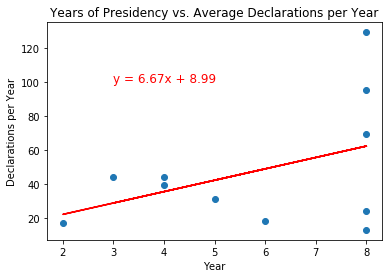

In [12]:
# Create scatter plot to visualize years of presidency vs. average declarations per year
x_val = pres_party['President Term']
y_val = pres_party["Avg Declarations per Year"] 
term_vs_declarations = plt.scatter(x=x_val, y=y_val)
plt.xlabel('Year')
plt.ylabel('Declarations per Year')
plt.title('Years of Presidency vs. Average Declarations per Year')
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_val, y_val)
regress_values = x_val * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_val,regress_values,"r-")
plt.annotate(line_eq,(3,100),fontsize=12,color="red")
plt.xlabel('Year')
plt.ylabel('Declarations per Year')
plt.show()

In [13]:
# Calculate correlation between average declarations per year and president term 
pres_party['Avg Declarations per Year'].corr(pres_party["President Term"])

0.4245303990429382

# Test Additional Theories

In [14]:
# Convert Disaster Length to integer in order to plot
dis_len_integer = cleaned_df["Disaster Length"].dt.days

In [15]:
# Merge cleaned_df with pres_party to pull President Term and Average Declarations per Year values to cleaned_df
cleaned_df = pd.merge(cleaned_df, pres_party[["President", "President Term", "Avg Declarations per Year"]], on="President", how="left")

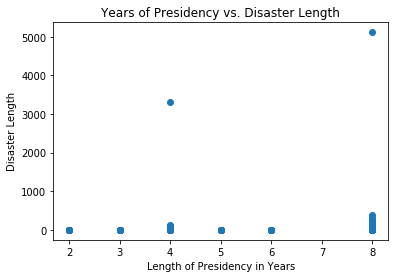

In [16]:
# Create scatter plot to visualize Disaster Length vs presidency length
term_vs_length = plt.scatter(x=cleaned_df['President Term'], y=(dis_len_integer))
plt.xlabel('Length of Presidency in Years')
plt.ylabel('Disaster Length')
plt.title('Years of Presidency vs. Disaster Length')
plt.show()

In [17]:
# Remove high/extreme values (above 3k) to better view data under 1k
over3k = cleaned_df.loc[cleaned_df['Disaster Length'] >= '3000 days']
under3k = cleaned_df.loc[cleaned_df['Disaster Length'] < '3000 days']

under3k

,Year,President,Party,Declaration Number,Declaration Type,Disaster Type,State,Start Date,End Date,Disaster Length,President Term,Avg Declarations per Year
0,1953,Dwight D. Eisenhower,Republican,DR-1,Disaster,Tornado,GA,05/02/1953,05/02/1953,0 days,8,13.250
1,1953,Dwight D. Eisenhower,Republican,DR-2,Disaster,Tornado,TX,05/15/1953,05/15/1953,0 days,8,13.250
2,1953,Dwight D. Eisenhower,Republican,DR-3,Disaster,Flood,LA,05/29/1953,05/29/1953,0 days,8,13.250
3,1953,Dwight D. Eisenhower,Republican,DR-4,Disaster,Tornado,MI,06/02/1953,06/02/1953,0 days,8,13.250
4,1953,Dwight D. Eisenhower,Republican,DR-5,Disaster,Flood,MT,06/06/1953,06/06/1953,0 days,8,13.250
...,...,...,...,...,...,...,...,...,...,...,...,...
3414,2016,Barack Obama,Democrat,DR-4290,Disaster,Flood,MN,09/21/2016,09/24/2016,3 days,8,95.375
3415,2016,Barack Obama,Democrat,DR-4292,Disaster,Flood,PA,10/20/2016,10/21/2016,1 days,8,95.375
3416,2016,Barack Obama,Democrat,DR-4293,Disaster,Fire,TN,11/28/2016,12/09/2016,11 days,8,95.375
3417,2016,Barack Obama,Democrat,DR-4296,Disaster,Storm,OR,12/14/2016,12/17/2016,3 days,8,95.375


In [18]:
# Convert disaster length to integer
under3k_integer = under3k["Disaster Length"].dt.days

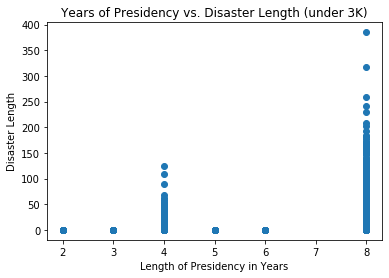

In [19]:
# Create scatter plot to visualize Presidency length vs Disaster Length 
presidency_vs_length = plt.scatter(x= under3k['President Term'], y=under3k_integer)
plt.xlabel('Length of Presidency in Years')
plt.ylabel('Disaster Length')
plt.title('Years of Presidency vs. Disaster Length (under 3K)')
plt.show()

In [20]:
# Checking correlation of Presidency length to Disaster Length without extreme values
under3k["President Term"].corr(under3k_integer)

0.18990893042391446

In [21]:
# Convert Disaster Length to integer so we can plot
cleaned_df["Length in Days"] = cleaned_df["Disaster Length"].dt.days

In [22]:
# Find president party count and average + median length of disasters by party
party_count = cleaned_df.groupby(["Party"])["President"].nunique()
average_length = cleaned_df.groupby(["Party"])["Length in Days"].mean()
median_length = cleaned_df.groupby(["Party"])["Length in Days"].median()

In [23]:
# Find average declarations by party
total_decs_party = pres_party.groupby(["Party"])["Disaster Count"].sum()

total_years_party = pres_party.groupby(["Party"])["President Term"].sum()

average_declarations = total_decs_party / total_years_party

In [24]:
# Create summary dataframe for data by party
party_summary = pd.DataFrame({"President Count": party_count,
                             "Average Length of Disaster": average_length,
                             "Median Length of Disaster": median_length,
                             "Average Number of Declarations per President": average_declarations})

party_summary

,President Count,Average Length of Disaster,Median Length of Disaster,Average Number of Declarations per President
Party,,,,
Democrat,5,14.366432,4.0,58.500000
Republican,6,16.132537,3.0,49.472222


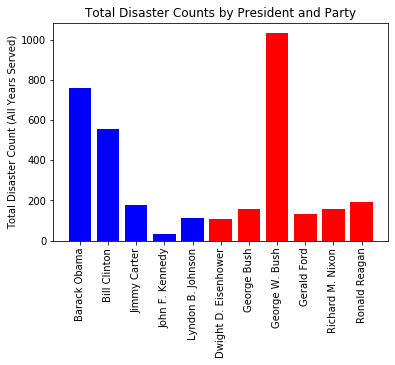

In [25]:
# Create bar graph to visualize Disaster Counts by President and Party
x_axis_pres = pres_party["President"]
y_axis_pres = pres_party["Disaster Count"]

mask1 = pres_party["Party"] == 'Democrat'
mask2 = pres_party["Party"] == 'Republican'

plt.bar(x_axis_pres[mask1], y_axis_pres[mask1], color = 'blue')
plt.bar(x_axis_pres[mask2], y_axis_pres[mask2], color = 'red')
xticks = plt.xticks(rotation="vertical")

plt.ylabel('Total Disaster Count (All Years Served)')
plt.title('Total Disaster Counts by President and Party')
plt.show()

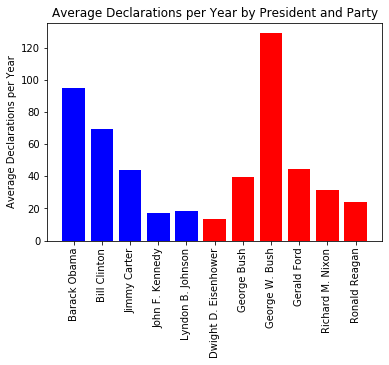

In [26]:
# Create bar graph to visualize Average Declarations by President and Party
x_axis_decs = pres_party["President"]
y_axis_decs = pres_party["Avg Declarations per Year"]

plt.bar(x_axis_decs[mask1], y_axis_decs[mask1], color = 'blue')
plt.bar(x_axis_decs[mask2], y_axis_decs[mask2], color = 'red')
xticks = plt.xticks(rotation="vertical")

plt.ylabel('Average Declarations per Year')
plt.title('Average Declarations per Year by President and Party')
plt.show()

In [27]:
# Create summary dataframe with total number of declarations each year
decs_by_year = cleaned_df.groupby(["Year"])["Declaration Number"].nunique()

decs_by_year_df = pd.DataFrame(data = {"Number of Declarations per Year": decs_by_year}).reset_index()
decs_by_year_df

,Year,Number of Declarations per Year
0,1953,13
1,1954,17
2,1955,18
3,1956,16
4,1957,16
...,...,...
59,2012,90
60,2013,68
61,2014,50
62,2015,56


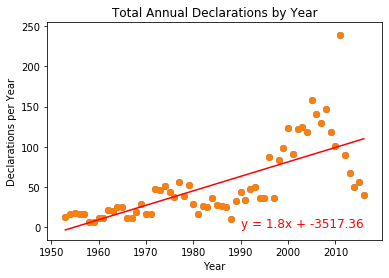

In [28]:
# Plot total declarations per year to see if total increases over the years
x_values = decs_by_year_df["Year"]
y_values = decs_by_year_df["Number of Declarations per Year"]
plt.scatter(x_values, y_values)
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(1990,0),fontsize=12,color="red")
plt.xlabel('Year')
plt.ylabel('Declarations per Year')
plt.title('Total Annual Declarations by Year')
plt.show()

In [29]:
# Find correlation of total declarations per year vs year
decs_by_year_df["Year"].corr(decs_by_year_df["Number of Declarations per Year"])

0.717755813248626

# Summary

In [30]:
# Question 1 - Does the term length of the president impact the number of federal emergencies declared in the United States?

# We found that the term length of the president does NOT impact the number of federal emergencies declared in the US. The correlation between the 2 factors was 0.42, 
# which does not imply a strong relationship. See Kernel #12 for scatter plot. 


In [31]:
# Question 2 - Does the term length of the president impact the duration of federal emergencies declared in the United States?

# We found that the term length of the president does NOT impact the duration of federal emergencies declared in the US. The correlation between the 2 factors was 0.19
# (after removing extreme values), which does not imply a strong relationship. See Kernel #19 for scatter plot. 


In [32]:
# Question 3 - Does the political party of the president impact the number of federal emergencies declared in the United States?

# We found that the political party of the president does NOT impact the number of federal emergencies declared in the US. Democratic Presidents averaged 58.5 declarations per year,
# while republican presidents averaged 49.5 declarations per year. We believe these averages are too close to imply a strong relationship. See Kernel # 24 for summary dataframe. 


In [33]:
# Question 4 - Has the number of disasters declared by FEMA risen or fallen over time?

# We found that generally, the number of disasters declared by FEMA has risen over time, despite a slight decrease in declarations after ~2005. The correlation between the Year 
# and the number of declarations declared each year was 0.72. We believe this implies a slight relationship. See Kernel #28 for scatter plot. 